# Time series analysis

A **time series** is a sequence of measurements from a system that varies in time.
Many of the tools we used in previous chapters, like linear regression, can also be used with time series data.
But there are additional methods that are particularly useful for this kind of data.

As examples, we'll look at two datasets, renewable electricity generation in the United States from 2001 to 2024, and weather data over the same interval.
We will develop methods to decompose a time series into a long-term trend and a repeated seasonal component.
We'll use linear regression models to fit and forecast trends.
And we'll try out a widely-used model for analyzing time series data, with the formal name "autoregressive integrated moving average" and the easier-to-say acronym ARIMA.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## Electricity

As an example of time-series data, we'll use a dataset from the U.S. Energy Information Administration -- it includes total electricity generation per month from renewable sources from 2021 to 2024.
Instructions for downloading the data are in the notebook for this chapter.

In [ ]:
# The following cell downloads the data, which I downloaded September 17, 2024 
# from https://www.eia.gov/electricity/data/browser/

In [212]:
filename = "Net_generation_for_all_sectors.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

<IPython.core.display.Javascript object>

After loading the data, we have make some transformations to get it into a format that's easy to work with.

In [226]:
elec = (
    pd.read_csv("Net_generation_for_all_sectors.csv", skiprows=4)
    .drop(columns=["units", "source key"])
    .set_index("description")
    .replace("--", np.nan)
    .transpose()
    .astype(float)
)

<IPython.core.display.Javascript object>

Each column is a sequence of monthly totals in gigawatt-hours (GWh).
Here are the column labels, showing the different sources of electricity, or "sectors".

In [227]:
elec.columns

Index(['Net generation for all sectors', 'United States',
       'United States : all fuels (utility-scale)', 'United States : nuclear',
       'United States : conventional hydroelectric',
       'United States : other renewables', 'United States : wind',
       'United States : all utility-scale solar', 'United States : geothermal',
       'United States : biomass',
       'United States : hydro-electric pumped storage',
       'United States : all solar',
       'United States : small-scale solar photovoltaic'],
      dtype='object', name='description')

<IPython.core.display.Javascript object>

The labels in the index are strings indicating months and years.

In [228]:
elec.index[:6]

Index(['Jan 2001', 'Feb 2001', 'Mar 2001', 'Apr 2001', 'May 2001', 'Jun 2001'], dtype='object')

<IPython.core.display.Javascript object>

It will be easier to work with this data if we replace these strings with Pandas `Timestamp` objects.
We can use the `date_range` function to generate a sequence of `Timestamp` objects, starting in January 2021 with the frequency code `"ME"`, which stands for "month end", which means that it fills in the last day of each month.

In [231]:
elec.index = pd.date_range(start="2001-01", periods=len(elec), freq="ME")
elec.index[:6]

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30'],
              dtype='datetime64[ns]', freq='ME')

<IPython.core.display.Javascript object>

As a first example, we'll look at how electricity generation from nuclear reactors has changed over this interval, and we'll decompose the time series into a long-term trend and a periodic component.

## Decomposition

Here are monthly totals of electricity generation from nuclear reactors in the United States from January 2001 to June 2024.

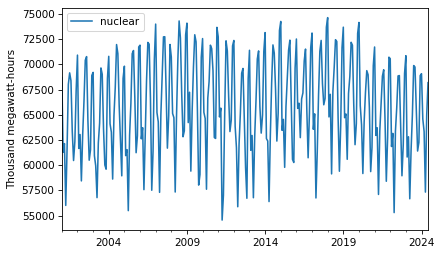

<IPython.core.display.Javascript object>

In [233]:
nuclear = elec["United States : nuclear"]
nuclear.plot(label="nuclear")

decorate(ylabel="GWh")

It looks like there are some long-term increases and decreases, but they are hard to see clearly because there are large variations from month to month.
To see the long-term trend more clearly, we can use the `rolling` method, which computes a "rolling average".
The `window=12` argument means it should select overlapping intervals of 12 months, so the first interval contains 12 measurements starting with the first, the second interval contains 12 measurements starting with the second, and so on.
For each interval, we compute the mean of the measurements.

In [ ]:
trend = nuclear.rolling(window=12).mean()

Here's what the results look like, along with the original data.

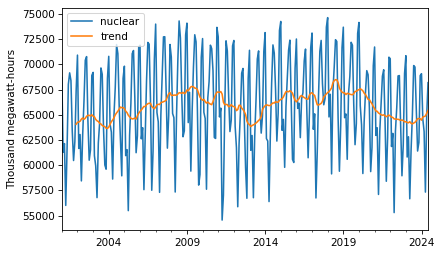

<IPython.core.display.Javascript object>

In [235]:
nuclear.plot(label="nuclear")
trend.plot(label="trend")
decorate(ylabel="GWh")

The trend is still quite variable.
We could smooth it more by using a longer window, but we'll stick with the 12-month window for now.

If we subtract the trend from the original data, the result is a "detrended" time series, which means that the long-term mean is close to constant.
Here's what it looks like.

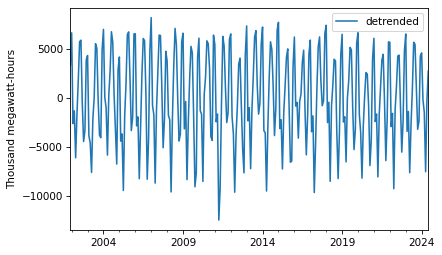

<IPython.core.display.Javascript object>

In [236]:
detrended = (nuclear - trend).dropna()
detrended.plot(label="detrended")
decorate(ylabel="GWh")

It looks like there is a repeating annual pattern, which makes sense because demand for electricity varies from one season to another, as it is used to generate heat in the winter and run air conditioning in the summer.
To describe this annual pattern we can group the data by month and compute average production.
Here's what the monthly averages look like.

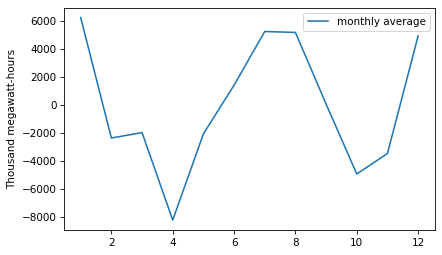

<IPython.core.display.Javascript object>

In [237]:
monthly_averages = detrended.groupby(detrended.index.month).mean()
monthly_averages.plot(label="monthly average")
decorate(ylabel="GWh")

Electricity production is highest during the coldest and warmest months.

We can use `monthly_averages` to construct the seasonal component of the data, which is a series the same length as `nuclear`, where the element for each month is the monthly average for that month.
Here's what it looks like.

<Axes: >

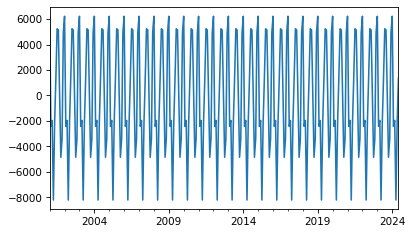

<IPython.core.display.Javascript object>

In [165]:
seasonal = monthly_averages[nuclear.index.month]
seasonal.index = nuclear.index
seasonal.plot()
decorate(ylabel="GWh")

Each 12-month period is identical to the others.

The sum of the trend and the seasonal component represents the expected value for each month.

In [243]:
expected = trend + seasonal

<IPython.core.display.Javascript object>

Here's what it looks like compared to the original series.

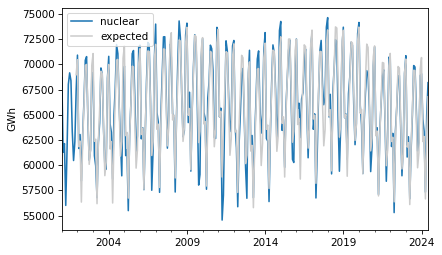

<IPython.core.display.Javascript object>

In [244]:
nuclear.plot(label="nuclear")
expected.plot(color="0.8", label="expected")
decorate(ylabel="GWh")

If we subtract this sum from the original signal, the result is the residual component, which represents the departure from the expected value for each month.

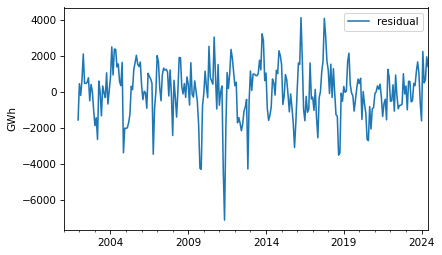

<IPython.core.display.Javascript object>

In [305]:
resid = nuclear - expected
resid.plot(label="residual")
decorate(ylabel="GWh")

We can think of the residual as the sum of everything in the world that affects energy production, but is not explained by the long-term trend or the seasonal component.
Among other things, that sum includes weather, equipment that's down for maintenance, and changes in demand due to specific events.
Since the residual is the sum of many unpredictable, and sometimes unknowable, factors, we often treat it as a random quantity.

Here's what the distribution of the residuals look like.

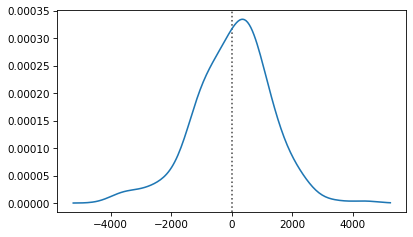

<IPython.core.display.Javascript object>

In [167]:
from thinkstats import plot_kde

plot_kde(resid.dropna())
decorate(xlabel='Residual (GWh)')

It resembles the bell curve of the normal distribution, which is consistent with the assumption that it is the sum of many random contributions.

To describe how well this model describes the original series, we can compute the coefficient of determination, which indicates how much smaller the variance of the residuals is, compared to the variance of the original series.

In [168]:
rsquared = 1 - resid.var() / nuclear.var()
rsquared

0.9248038288734188

<IPython.core.display.Javascript object>

The $R^2$ value is about 0.92, which means that the long-term trend and seasonal component account for 92% of the variability in the series.
This coefficient of determination is substantially higher than the ones we saw in the previous chapter, but that's common with time series data -- especially in a case like this where we've constructed the model to resemble the data. 

The process we've just walked through is called "seasonal decomposition".
StatsModels provides a function that does it, called `seasonal_decompose`.

It takes the original series as an argument and a string that specifies the type of model.
What we just computed is the additive model, because the series is decomposed into the sum of a trend, seasonal component, and residual.
We'll see the multiplicative model soon.
The third argument is the period, which is the length of one seasonal cycle.
In this dataset, we assume that the period of the seasonal component is 12 months.

In [246]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(nuclear, model="additive", period=12)

statsmodels.tsa.seasonal.DecomposeResult

<IPython.core.display.Javascript object>

The result is an object that contains the three components.
We'll use the following function to plot them.

In [169]:
def plot_decomposition(original, decomposition):
    plt.figure(figsize=(6, 5))

    plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color="C0")
    plt.ylabel("Original")

    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label="Trend", color="C1")
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label="Seasonal", color="C2")
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label="Residual", color="C3")
    plt.ylabel("Residual")

    plt.tight_layout()

<IPython.core.display.Javascript object>

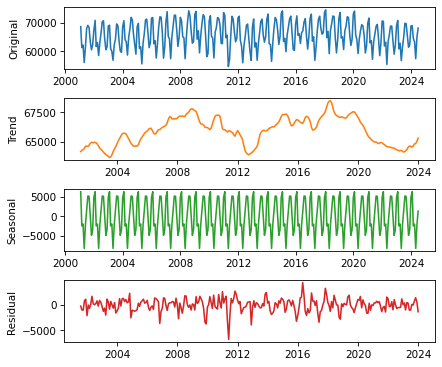

<IPython.core.display.Javascript object>

In [171]:
plot_decomposition(nuclear, decomposition)

Seasonal decomposition provides some insight into the structure of a time series.
It is also useful for making forecasts.

## Prediction

We can use the results from seasonal decomposition to predict the future.
To demonstrate, we'll use the following function to split the time series into a training series we'll use to generate predictions and a test series we'll use to see whether they are accurate. 

In [463]:
def split_series(series, n=60):
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

<IPython.core.display.Javascript object>

With `n=60`, the duration of the test series is five years, starting in July 2019.

In [464]:
training, test = split_series(nuclear)
test.index[0]

Timestamp('2019-07-31 00:00:00')

<IPython.core.display.Javascript object>

Now, suppose it's June 2019 and you are asked to generate a five-year forecast for electricity production from nuclear generators.
We'll start with a seasonal decomposition of the training data.
With the argument `two_sided=False`, the trend is aligned so the value at each point is the average of the previous 12 months.

In [465]:
decomposition = seasonal_decompose(
    training, model="additive", period=12, two_sided=False
)
trend = decomposition.trend

<IPython.core.display.Javascript object>

Now we'll fit a linear model to the trend.
The dependent variable, `months`, is the number of months from the beginning of the series.

In [466]:
import statsmodels.formula.api as smf

months = np.arange(len(trend))
data = pd.DataFrame({"trend": trend, "months": months}).dropna()
results = smf.ols("trend ~ months", data=data).fit()

<IPython.core.display.Javascript object>

Here is a summary of the results.

In [467]:
from thinkstats import display_summary

display_summary(results)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.476e+04,137.046,472.527,0.000,6.45e+04,6.5e+04
months,10.9886,1.044,10.530,0.000,8.931,13.046


R-squared:,0.3477


<IPython.core.display.Javascript object>

The $R^2$ value is about 0.35, which suggests that the model does not fit the data particularly well.
We can get a better sense of that by plotting the fitted line.
We'll use the `predict` method to retrodict the values in the training data and predict the values in the test data.

In [468]:
months = np.arange(len(training) + len(test))
df = pd.DataFrame({"months": months})
pred_trend = results.predict(df)
pred_trend.index = nuclear.index

<IPython.core.display.Javascript object>

Here's the trend component and the linear model.

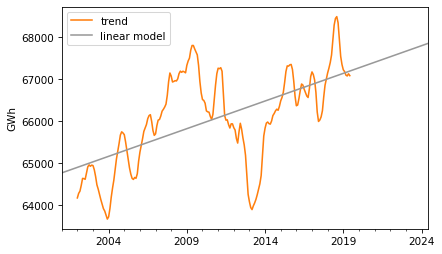

<IPython.core.display.Javascript object>

In [469]:
trend.plot(color="C1")
pred_trend.plot(color="0.6", label="linear model")
decorate(ylabel="GWh")

There's a lot going on that's not captured by the linear model, but it looks like there is a generally increasing trend.

To predict the seasonal component, we'll use the seasonal component from the decomposition to compute a `Series` of monthly averages.

In [470]:
seasonal = decomposition.seasonal
monthly_averages = seasonal.groupby(seasonal.index.month).mean()

<IPython.core.display.Javascript object>

Now we can compute the seasonal component by looking up the dates from the fitted line in `monthly_averages`.

In [471]:
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index

<IPython.core.display.Javascript object>

Finally, to generate predictions, we'll add the seasonal component to the trend.

In [472]:
pred = pred_trend + pred_seasonal

<IPython.core.display.Javascript object>

Here's the training data and the predictions.

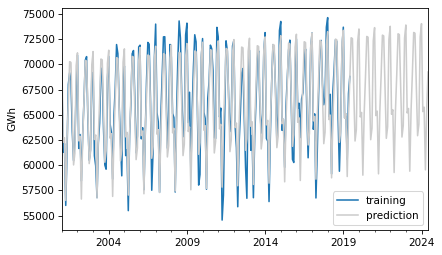

<IPython.core.display.Javascript object>

In [473]:
training.plot(label="training")
pred.plot(color="0.8", label="prediction")
decorate(ylabel="GWh")

The predictions fit the training data reasonably well, and the forecast looks like a reasonable projection of the data, based on the assumption that the long-term trend will continue.

Now, from the vantage point of the future, let's see how accurate this forecast turned out to be.
Here is are the predicted and actual values for the five-year interval from July 2019. 

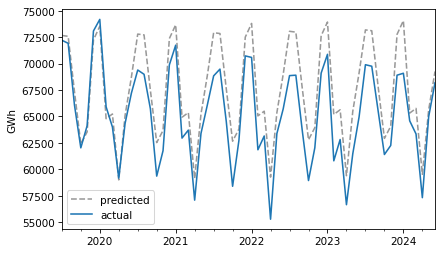

<IPython.core.display.Javascript object>

In [430]:
future = pred[test.index]
future.plot(ls="--", color="0.6", label="predicted")
test.plot(label="actual")
decorate(ylabel="GWh")

The first year of the forecast was pretty good, but production from nuclear reactors in 2020 was lower than expected -- probably due to the COVID-19 pandemic -- and it never returned to the long-term trend.

As Yogi Berra (allegedly) said, "It's tough to make predictions, especially about the future."

## Multiplicative Model

The additive model we used in the previous section is based on the assumption that the time series is well modeled as the *sum* of a long-term trend, a seasonal component, and a residual component -- which implies that the magnitude of the seasonal component and the residuals does not vary over time.

As an example that violates this assumption, let's look at small-scale solar electricity production since 2014.

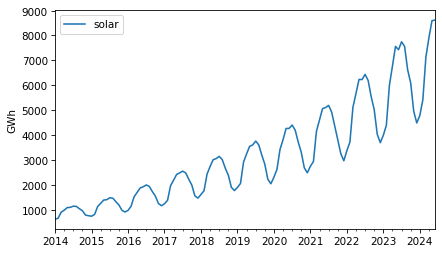

<IPython.core.display.Javascript object>

In [475]:
solar = elec["United States : small-scale solar photovoltaic"].dropna()
solar.plot(label="solar")
decorate(ylabel="GWh")

Over this interval, total production has increased several times over.
And it's clear that the magnitude of seasonal variation has increased as well.

If suppose that the magnitudes of seasonal and random variation are proportional to the magnitude of the trend, that suggests an alternative to the additive model in which the time series is the *product* of a trend, a seasonal component, and a residual component.

To try out this multiplicative model, we'll split this series into training and test sets.

In [476]:
training, test = split_series(solar)

<IPython.core.display.Javascript object>

And call `seasonal_decompose` with the `model=multiplicative` argument.

In [477]:
decomposition = seasonal_decompose(
    training, model="multiplicative", period=12, two_sided=False
)

<IPython.core.display.Javascript object>

Here's what the results look like.

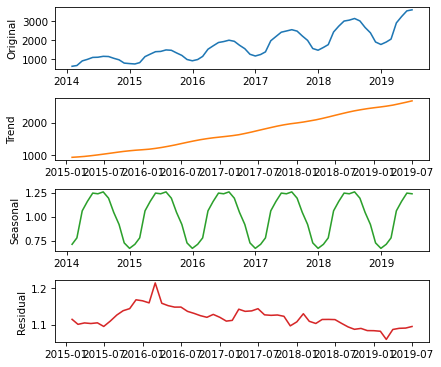

<IPython.core.display.Javascript object>

In [478]:
plot_decomposition(training, decomposition)

Now the seasonal and residual components are multiplicative factors.
So, it looks like the seasonal component varies from about 25% below the trend to 25% above.
And the residual component is usually less than 5% either way, with the exception of some larger factors in the first period.  

In [479]:
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

<IPython.core.display.Javascript object>

The $R^2$ value of this model is very high.

In [480]:
rsquared = 1 - resid.var() / training.var()
rsquared

0.9999999987169766

<IPython.core.display.Javascript object>

The production of a solar panel is almost entirely a function of the sunlight it's exposed to, so it makes sense that it follows an annual cycle so closely.

To predict the long term trend, we'll use a quadratic model.

In [481]:
months = range(len(training))
data = pd.DataFrame({"trend": trend, "months": months}).dropna()
results = smf.ols("trend ~ months + I(months**2)", data=data).fit()

<IPython.core.display.Javascript object>

In the Patsy formula, the term `"I(months**2)"` adds a quadratic term to the model, so we don't have to compute it explicitly.
Here are the results.

In [482]:
display_summary(results)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,639.2466,19.308,33.107,0.000,600.484,678.010
months,20.1013,1.105,18.198,0.000,17.884,22.319
I(months ** 2),0.1762,0.014,12.480,0.000,0.148,0.205


R-squared:,0.9983


<IPython.core.display.Javascript object>

Now we can use the model to compute the expected value of the trend for the past and future.

In [497]:
months = range(len(solar))
df = pd.DataFrame({"months": months})
pred_trend = results.predict(df)
pred_trend.index = solar.index

<IPython.core.display.Javascript object>

Here's what it looks like.

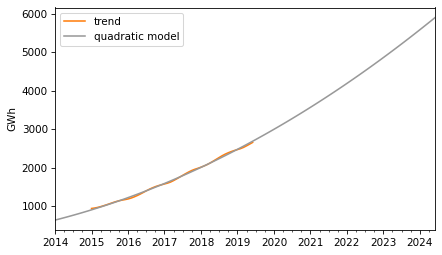

<IPython.core.display.Javascript object>

In [498]:
trend.plot(color="C1")
pred_trend.plot(color="0.6", label="quadratic model")
decorate(ylabel="GWh")

The quadratic model fits the past trend well and generates predictions that seem plausible.
Now we can use the seasonal component from the decomposition to predict the seasonal component.

In [499]:
monthly_averages = seasonal.groupby(seasonal.index.month).mean()
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index

<IPython.core.display.Javascript object>

Finally, to compute "retrodictions" for past values and predictions for the future, we multiply the trend and the seasonal component.

In [500]:
pred = pred_trend * pred_seasonal

<IPython.core.display.Javascript object>

Here are the results along with the training data.

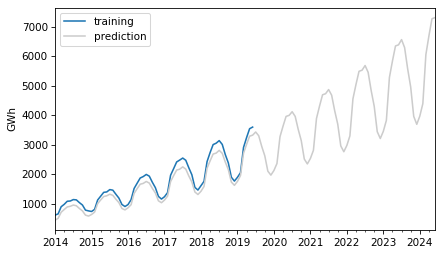

<IPython.core.display.Javascript object>

In [501]:
training.plot(label="training")
pred.plot(color="0.8", label="prediction")
decorate(ylabel="GWh")

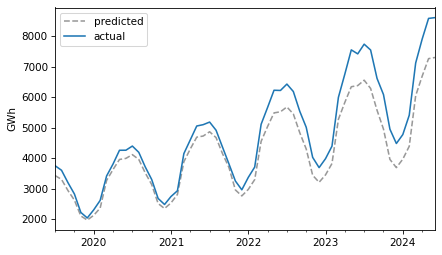

<IPython.core.display.Javascript object>

In [502]:
future = pred[test.index]
future.plot(ls="--", color="0.6", label="predicted")
test.plot(label="actual")
decorate(ylabel="GWh")

## Autoregression


<Axes: >

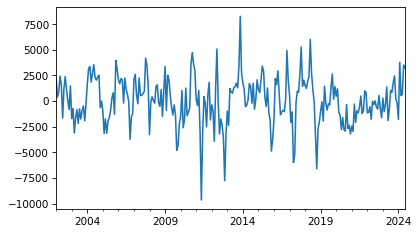

<IPython.core.display.Javascript object>

In [51]:
diff = (nuclear - nuclear.shift(12)).dropna()
diff.plot()

In [52]:
df_ar = pd.DataFrame({"diff": diff})
for lag in [1, 2, 3]:
    df_ar[f"lag{lag}"] = diff.shift(lag)

df_ar = df_ar.dropna()

<IPython.core.display.Javascript object>

In [53]:
df_ar.corr()[["diff"]]

,diff
diff,1.000000
lag1,0.562212
lag2,0.292454
lag3,0.222228


<IPython.core.display.Javascript object>

In [54]:
def make_formula(df):
    y = df.columns[0]
    xs = " + ".join(df.columns[1:])
    return f"{y} ~ {xs}"

<IPython.core.display.Javascript object>

In [55]:
formula = make_formula(df_ar)
results_ar = smf.ols(formula=formula, data=df_ar).fit()
display_summary(results_ar)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,24.2674,114.674,0.212,0.833,-201.528,250.063
lag1,0.5847,0.061,9.528,0.000,0.464,0.706
lag2,-0.0908,0.071,-1.277,0.203,-0.231,0.049
lag3,0.1026,0.062,1.666,0.097,-0.019,0.224


R-squared:,0.3239


<IPython.core.display.Javascript object>

<Axes: >

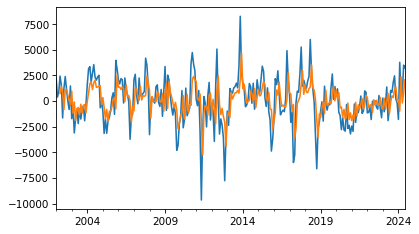

<IPython.core.display.Javascript object>

In [56]:
pred_ar = results_ar.predict(df_ar)
diff.plot()
pred_ar.plot()

In [57]:
resid_ar = results_ar.resid
R2 = 1 - resid_ar.var() / diff.var()
R2

0.3190252265690783

<IPython.core.display.Javascript object>

## Moving Average

In [58]:
df_ma = pd.DataFrame({"resid": resid_ar})

for lag in [1, 6]:
    df_ma[f"lag{lag}"] = resid_ar.shift(lag)

df_ma = df_ma.dropna()

<IPython.core.display.Javascript object>

In [59]:
formula = make_formula(df_ma)
formula

'resid ~ lag1 + lag6'

<IPython.core.display.Javascript object>

In [60]:
results_ma = smf.ols(formula=formula, data=df_ma).fit()
display_summary(results_ma)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-14.0016,114.697,-0.122,0.903,-239.863,211.860
lag1,0.0014,0.062,0.023,0.982,-0.120,0.123
lag6,-0.1592,0.063,-2.547,0.011,-0.282,-0.036


R-squared:,0.0247


<IPython.core.display.Javascript object>

In [61]:
pred_ma = results_ma.predict(df_ma)

<IPython.core.display.Javascript object>

In [62]:
pred_diff = pred_ar + pred_ma

<IPython.core.display.Javascript object>

In [63]:
resid = (diff - pred_diff).dropna()
R2 = 1 - resid.var() / diff.var()
R2

0.3315101001391231

<IPython.core.display.Javascript object>

In [64]:
pred_diff = pd.Series(pred_diff, index=nuclear.index)
offset = pred_diff.isna().sum()
offset

21

<IPython.core.display.Javascript object>

In [65]:
pred_series = pd.Series(index=nuclear.index, dtype=float)
pred_series.iloc[:offset] = nuclear.iloc[:offset]

<IPython.core.display.Javascript object>

In [66]:
for i in range(offset, len(pred_series)):
    pred_series.iloc[i] = pred_series.iloc[i - 12] + pred_diff.iloc[i]

pred_series[:offset] = np.nan

<IPython.core.display.Javascript object>

<Axes: >

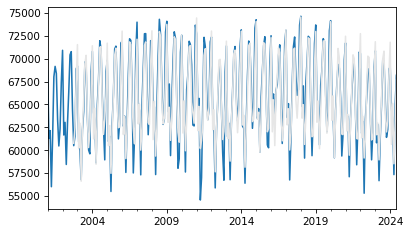

<IPython.core.display.Javascript object>

In [67]:
nuclear.plot()
pred_series.plot(color="0.9")

In [68]:
resid = (nuclear - pred_series).dropna()
R2 = 1 - resid.var() / nuclear.var()
R2

0.8586566911201015

<IPython.core.display.Javascript object>

And it's a similar process to generate forecasts...

## ARIMA

In [115]:
import statsmodels.tsa.api as tsa

model = tsa.ARIMA(nuclear, order=(3, 0, [1, 6]), seasonal_order=(0, 1, 0, 12))
results_arima = model.fit()
display_summary(results_arima)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.0458,0.379,0.121,0.904,-0.697,0.788
ar.L2,-0.0035,0.116,-0.030,0.976,-0.230,0.223
ar.L3,0.0375,0.049,0.769,0.442,-0.058,0.133
ma.L1,0.2154,0.382,0.564,0.573,-0.533,0.964
ma.L6,-0.0672,0.019,-3.500,0.000,-0.105,-0.030
sigma2,3.473e+06,1.9e-07,1.83e+13,0.000,3.47e+06,3.47e+06


<IPython.core.display.Javascript object>

In [116]:
fittedvalues = results_arima.fittedvalues[offset:]

<IPython.core.display.Javascript object>

<Axes: >

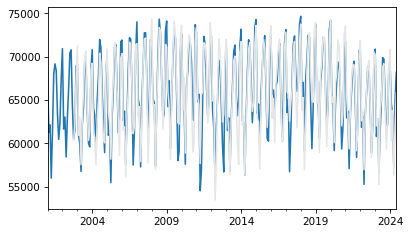

<IPython.core.display.Javascript object>

In [118]:
nuclear.plot()
fittedvalues.plot(color="0.9")

In [119]:
resid = nuclear - fittedvalues
R2 = 1 - resid.var() / nuclear.var()
R2

0.8262717330784233

<IPython.core.display.Javascript object>

In [120]:
forecast = results_arima.get_forecast(steps=60)

<IPython.core.display.Javascript object>

In [121]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_ci.columns = ["lower", "upper"]

<IPython.core.display.Javascript object>

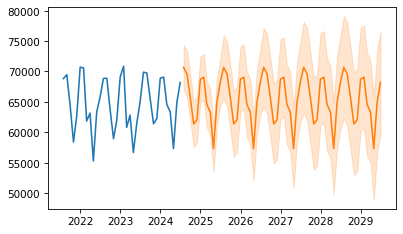

<IPython.core.display.Javascript object>

In [122]:
recent = nuclear.iloc[-36:]
plt.plot(recent.index, recent)
plt.fill_between(
    forecast_ci.index, forecast_ci.lower, forecast_ci.upper, color="C1", alpha=0.2
)
plt.plot(forecast_mean.index, forecast_mean)

## Exogenous

In [123]:
temps = pd.read_csv("monthly-average-surface-temperatures-by-year.csv")
temps.head()

,Entity,Code,Year,2024,2023,2022,2021,2020,2019,2018,...,1959,1958,1956,1954,1952,1957,1955,1953,1951,1950
0,Afghanistan,AFG,1,3.300064,-4.335608,-0.322859,-1.001608,-2.560545,0.585145,1.042471,...,-2.333814,0.576404,-3.351925,-2.276692,-2.812619,-4.239172,-2.191683,-2.915993,-3.126317,-2.655707
1,Afghanistan,AFG,2,1.024550,4.187041,2.165870,5.688000,2.880046,0.068664,3.622793,...,-1.545529,0.264962,0.455350,-0.304205,0.798226,-2.747945,1.999074,1.983414,-2.642800,-3.996040
2,Afghanistan,AFG,3,5.843506,10.105444,10.483686,9.777976,6.916731,5.758049,10.794412,...,5.942937,7.716459,5.090270,4.357703,4.796146,4.434027,7.066073,4.590406,3.054388,3.491112
3,Afghanistan,AFG,4,11.627398,14.277164,17.227650,15.168276,12.686832,13.838840,14.321226,...,13.752827,14.712909,11.982360,12.155265,13.119270,8.263829,10.418768,11.087193,9.682878,8.332797
4,Afghanistan,AFG,5,18.957850,19.078170,19.962734,19.885902,18.884047,18.461287,18.100782,...,17.388723,16.352045,20.125462,18.432117,17.614851,15.505956,15.599709,17.865084,17.095737,17.329062


<IPython.core.display.Javascript object>

In [124]:
temp_us = temps.query("Code == 'USA'")
columns = [str(year) for year in range(2001, 2025)]
temp_series = temp_us.loc[:, columns].transpose().stack()
temp_series.index = pd.date_range(start="2001-01", periods=len(temp_series), freq="ME")

<IPython.core.display.Javascript object>

<Axes: >

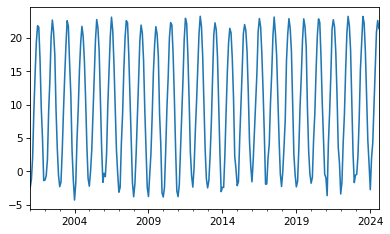

<IPython.core.display.Javascript object>

In [125]:
temp_series.plot()

<Axes: >

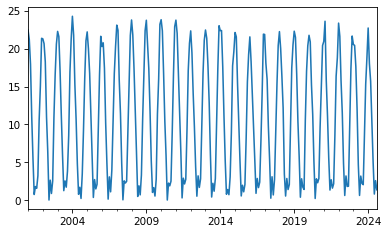

<IPython.core.display.Javascript object>

In [126]:
temp_deviation = (temp_series - 20).abs()
temp_deviation.plot()

In [127]:
data = pd.DataFrame({"nuclear": nuclear, "temp": temp_deviation}).dropna()

<IPython.core.display.Javascript object>

In [128]:
results = smf.ols("nuclear ~ temp", data=data).fit()
display_summary(results)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.617e+04,479.821,137.906,0.000,6.52e+04,6.71e+04
temp,-31.6990,35.487,-0.893,0.372,-101.555,38.157


R-squared:,0.002842


<IPython.core.display.Javascript object>

In [129]:
model = tsa.ARIMA(
    nuclear, order=(3, 0, [1, 6]), seasonal_order=(0, 1, 0, 12), exog=data["temp"]
)
results_arima = model.fit()
display_summary(results_arima)

,coef,std err,z,P>|z|,[0.025,0.975]
temp,-156.3105,88.099,-1.774,0.076,-328.982,16.361
ar.L1,-0.0074,0.380,-0.019,0.985,-0.752,0.737
ar.L2,-0.0014,0.114,-0.012,0.990,-0.225,0.223
ar.L3,0.0347,0.052,0.670,0.503,-0.067,0.136
ma.L1,0.2518,0.382,0.660,0.510,-0.496,1.000
ma.L6,-0.0609,0.019,-3.210,0.001,-0.098,-0.024
sigma2,3.483e+06,0.005,6.67e+08,0.000,3.48e+06,3.48e+06


<IPython.core.display.Javascript object>

<Axes: >

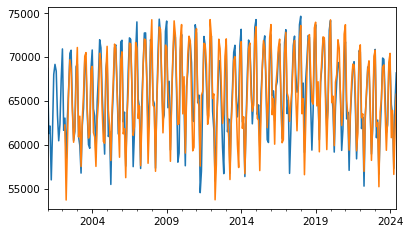

<IPython.core.display.Javascript object>

In [130]:
fittedvalues = results_arima.fittedvalues[14:]
nuclear.plot()
fittedvalues.plot()

In [131]:
resid = nuclear - fittedvalues
R2 = 1 - resid.var() / nuclear.var()
R2

0.8222537833569468

<IPython.core.display.Javascript object>

## Glossary

-   **time series**: A dataset where each value is associated with a timestamp, often a series of measurements and the times they were collected.

-   **window**: A sequence of consecutive values in a time series, often used to compute a moving average.

-   **moving average**: One of several statistics intended to estimate the underlying trend in a time series by computing averages (of some kind) for a series of overlapping windows.

-   **rolling mean**: A moving average based on the mean value in each window.

-   **exponentially-weighted moving average (EWMA)**: A moving average based on a weighted mean that gives the highest weight to the most recent values, and exponentially decreasing weights to earlier values.

-   **span**: A parameter of EWMA that determines how quickly the weights decrease.

-   **serial correlation**: Correlation between a time series and a shifted or lagged version of itself.

-   **lag**: The size of the shift in a serial correlation or autocorrelation.

-   **autocorrelation**: A more general term for a serial correlation with any amount of lag.

-   **autocorrelation function**: A function that maps from lag to serial correlation.

-   **stationary**: A model is stationary if the parameters and the distribution of residuals does not change over time.

## Exercises

<Axes: >

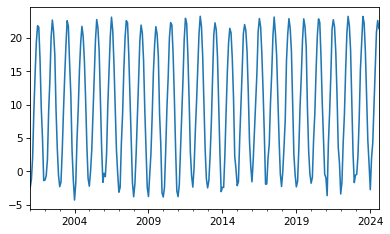

<IPython.core.display.Javascript object>

In [132]:
temp_series.plot()

In [133]:
decomposition = seasonal_decompose(temp_series, model="additive", period=12)

<IPython.core.display.Javascript object>

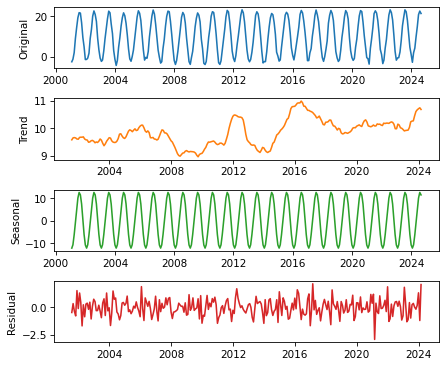

<IPython.core.display.Javascript object>

In [134]:
plot_decomposition(temp_series, decomposition)

In [135]:
trend = decomposition.trend

<IPython.core.display.Javascript object>

In [136]:
t0 = trend.index[0]
years = trend.index.year - t0.year
months = years * 12 + trend.index.month - t0.month

<IPython.core.display.Javascript object>

In [137]:
data = pd.DataFrame({"trend": trend, "months": months}).dropna()

<IPython.core.display.Javascript object>

In [138]:
results = smf.ols("trend ~ months + I(months**2)", data=data).fit()
display_summary(results)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.5552,0.077,124.614,0.000,9.404,9.706
months,0.0002,0.001,0.162,0.871,-0.002,0.003
I(months ** 2),1.04e-05,4.28e-06,2.430,0.016,1.97e-06,1.88e-05


R-squared:,0.3003


<IPython.core.display.Javascript object>

In [139]:
month_range = np.arange(months.min(), months.max() + 5 * 12)
df = pd.DataFrame({"months": month_range})
pred_trend = results.predict(df)

<IPython.core.display.Javascript object>

In [140]:
pred_trend.index = [t0 + pd.DateOffset(months=months) for months in month_range]

<IPython.core.display.Javascript object>

<Axes: >

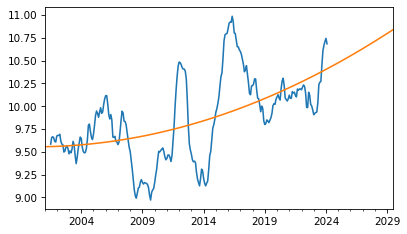

<IPython.core.display.Javascript object>

In [141]:
trend.plot()
pred_trend.plot()

In [142]:
seasonal = decomposition.seasonal
monthly_averages = seasonal.groupby(seasonal.index.month).mean()

<IPython.core.display.Javascript object>

In [143]:
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index

<IPython.core.display.Javascript object>

<Axes: >

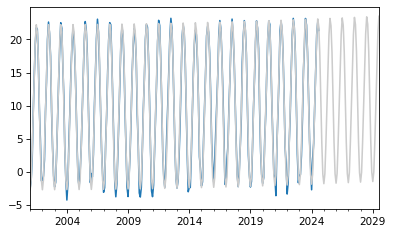

<IPython.core.display.Javascript object>

In [144]:
pred = pred_trend + pred_seasonal

temp_series.plot()
pred.plot(color="0.8")

## Exercise

Utility-scale solar power, multiplicative model

In [145]:
solar = elec["United States : all utility-scale solar"].dropna()

<IPython.core.display.Javascript object>

In [146]:
solar = solar[solar.index.year >= 2014]

<IPython.core.display.Javascript object>

<Axes: >

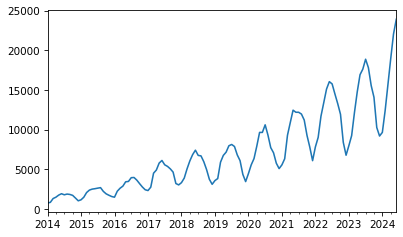

<IPython.core.display.Javascript object>

In [147]:
solar.plot()

In [148]:
decomposition = seasonal_decompose(solar, model="multiplicative", period=12)

<IPython.core.display.Javascript object>

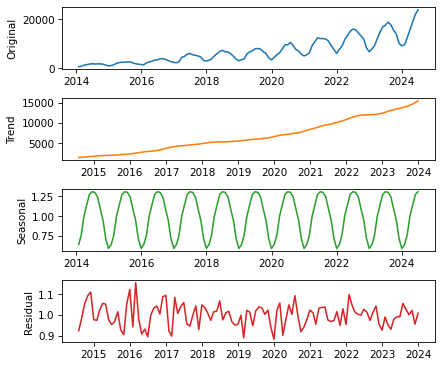

<IPython.core.display.Javascript object>

In [149]:
plot_decomposition(solar, decomposition)

In [150]:
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

<IPython.core.display.Javascript object>

In [151]:
rsquared = 1 - resid.var() / solar.var()
rsquared

0.9999999998865255

<IPython.core.display.Javascript object>

In [152]:
t0 = trend.index[0]
years = trend.index.year - t0.year
months = years * 12 + trend.index.month - t0.month

<IPython.core.display.Javascript object>

In [153]:
data = pd.DataFrame({"trend": trend, "months": months}).dropna()

<IPython.core.display.Javascript object>

In [154]:
results = smf.ols("trend ~ months + I(months**2)", data=data).fit()
display_summary(results)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1543.9346,111.941,13.792,0.000,1322.116,1765.753
months,27.8715,4.100,6.798,0.000,19.747,35.996
I(months ** 2),0.7041,0.032,22.052,0.000,0.641,0.767


R-squared:,0.993


<IPython.core.display.Javascript object>

In [155]:
month_range = np.arange(months.min(), months.max() + 5 * 12)
df = pd.DataFrame({"months": month_range})
pred_trend = results.predict(df)

<IPython.core.display.Javascript object>

In [156]:
pred_trend.index = [t0 + pd.DateOffset(months=months) for months in month_range]

<IPython.core.display.Javascript object>

<Axes: >

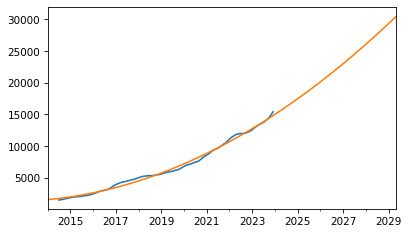

<IPython.core.display.Javascript object>

In [157]:
trend.plot()
pred_trend.plot()

In [158]:
monthly_averages = seasonal.groupby(seasonal.index.month).mean()

<IPython.core.display.Javascript object>

<Axes: >

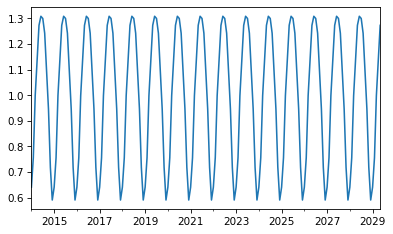

<IPython.core.display.Javascript object>

In [159]:
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index
pred_seasonal.plot()

<Axes: >

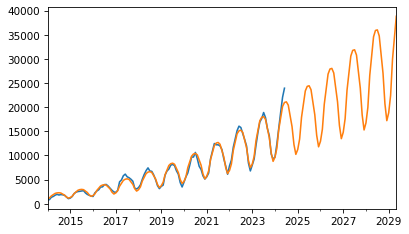

<IPython.core.display.Javascript object>

In [160]:
pred = pred_trend * pred_seasonal

solar.plot()
pred.plot()

## Exercise

<Axes: >

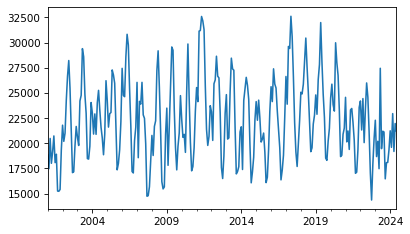

<IPython.core.display.Javascript object>

In [184]:
hydro = elec["United States : conventional hydroelectric"]
hydro.plot()

In [205]:
import statsmodels.tsa.api as tsa

model = tsa.ARIMA(hydro, order=([1, 6], 0, [6]), seasonal_order=(0, 1, 0, 12))
results_arima = model.fit()
display_summary(results_arima)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5387,0.039,13.680,0.000,0.461,0.616
ar.L6,-0.4041,0.046,-8.722,0.000,-0.495,-0.313
ma.L6,0.9405,0.043,22.009,0.000,0.857,1.024
sigma2,4.437e+06,3.58e+05,12.396,0.000,3.74e+06,5.14e+06


<IPython.core.display.Javascript object>

In [190]:
fittedvalues = results_arima.fittedvalues[offset:]

<IPython.core.display.Javascript object>

<Axes: >

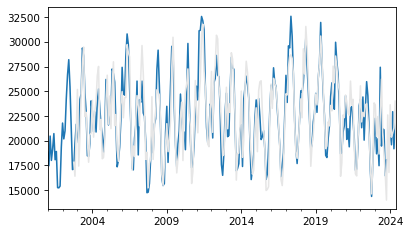

<IPython.core.display.Javascript object>

In [191]:
hydro.plot()
fittedvalues.plot(color="0.9")

In [193]:
resid = hydro - fittedvalues
R2 = 1 - resid.var() / nuclear.var()
R2

0.805826421418809

<IPython.core.display.Javascript object>

In [194]:
forecast = results_arima.get_forecast(steps=60)

<IPython.core.display.Javascript object>

In [195]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_ci.columns = ["lower", "upper"]

<IPython.core.display.Javascript object>

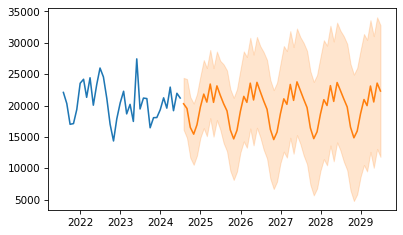

<IPython.core.display.Javascript object>

In [196]:
recent = hydro.iloc[-36:]
plt.plot(recent.index, recent)
plt.fill_between(
    forecast_ci.index, forecast_ci.lower, forecast_ci.upper, color="C1", alpha=0.2
)
plt.plot(forecast_mean.index, forecast_mean)